
# Fashion GAN

In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

    !cp '/content/gdrive/My Drive/s_data.pickle' s_data.pickle
    !cp '/content/gdrive/My Drive/s_img_mean.pickle' s_img_mean.pickle
    !cp '/content/gdrive/My Drive/s_seg.pickle' s_seg.pickle
    !cp '/content/gdrive/My Drive/Colab Notebooks/data/ind.mat' ind.mat
    !cp '/content/gdrive/My Drive/Colab Notebooks/data/language_original.mat' language_original.mat

## Imports

In [2]:
import torch
import h5py
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using device: cuda:0


## Loading data from file

(78979, 1, 128, 128)
the lady was wearing a blue long-sleeved blouse.


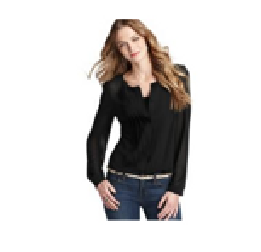

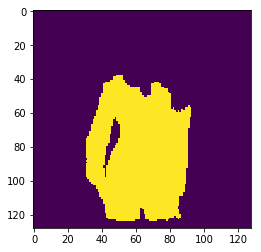

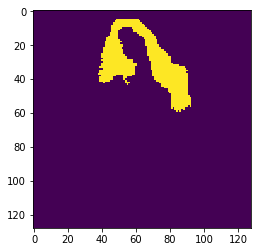

In [230]:

annotations = loadmat('language_original.mat')

if colab:
    data = pickle.load( open("s_data.pickle",'rb'))
    mean = np.transpose(pickle.load( open("s_img_mean.pickle",'rb')))
    segmentation = pickle.load( open("s_seg.pickle",'rb'))
else:
    f = h5py.File('G2.h5', 'r')
    data = f['ih']
    segmentation = f['b_']
    mean = np.transpose(f['ih_mean'])
    del f

print(segmentation.shape)
i = 0
img = np.transpose(data[i,:,:,:])
seg = np.transpose(segmentation[i,0,:,:])

print(annotations['engJ'][i][0][0])
img = img+mean
img[img>1]=1
img[img<0]=0
plt.imshow(img)
plt.axis('off')
plt.savefig('original.png')
plt.show()
plt.imshow((seg != 0) & (seg != 1) & (seg != 2))
plt.show()
plt.imshow(seg == 1)
plt.show()


## Preprocessing

In [12]:
n_data_points = 40000#len(segmentation)-len(segmentation)%100
segmentation = segmentation[:n_data_points]
vocab_size = 539
def one_hot_int(data,n_unique):
    out = np.zeros((len(data),n_unique))
    for i,datapoint in enumerate(data):
        out[i,datapoint-1] = 1
    return out

def one_hot_codeJ(n_unique):
    out = np.zeros((len(segmentation),n_unique))
    for i in range(len(segmentation)):
        datapoint = np.transpose(annotations['codeJ'][i][0])[0]
        for datapoint_i  in datapoint:
            out[i,datapoint-1] = 1
    return out

codeJ = torch.tensor(np.reshape(one_hot_codeJ(vocab_size)[:n_data_points],(n_data_points,1,vocab_size)),dtype=torch.float)
color = np.reshape(np.transpose(annotations['color_'])[0][:n_data_points],(n_data_points,1))
cate_new = np.reshape(np.transpose(annotations['cate_new'])[0][:n_data_points],(n_data_points,1))
gender = np.reshape(np.transpose(annotations['gender_'])[0][:n_data_points],(n_data_points,1))
sleeve = np.reshape(np.transpose(annotations['sleeve_'])[0][:n_data_points],(n_data_points,1))
attribute_data = torch.tensor(np.concatenate([color,cate_new,gender,sleeve],axis=1),dtype=torch.float)
att_mean = attribute_data.mean(dim=0,keepdim=True)
att_std = attribute_data.std(dim=0,keepdim=True)

attribute_data = (attribute_data-att_mean)/att_std
attribute_data = attribute_data.view((n_data_points,4,1,1))

In [13]:
import torch.nn as nn
def downsample_seg(kernel_size):
    data_out = torch.Tensor(np.zeros((len(attribute_data),4,128//kernel_size[0],128//kernel_size[1])))
    downsample = nn.AvgPool2d(kernel_size)

    background = downsample(torch.Tensor(segmentation[:,0,:,:] == 0))
    hair = downsample(torch.Tensor(segmentation[:,0,:,:] == 1))
    face = downsample(torch.Tensor(segmentation[:,0,:,:] == 2))
    rest = downsample(torch.Tensor((segmentation[:,0,:,:] != 0) & (segmentation[:,0,:,:] != 1) & (segmentation[:,0,:,:] != 2)))
    
    data_out[:,0,:,:] = background
    data_out[:,1,:,:] = hair
    data_out[:,2,:,:] = face
    data_out[:,3,:,:] = rest
    
    return data_out

# MEMORY_ERROR (we should figure something out to not load the entire data set in at once)
def seven_channel_seg(segmentation,n_data_points):
    data_out = torch.Tensor(np.zeros((n_data_points,7,128,128)))
    for channel in range(7):
        data_out[:,channel,:,:] = torch.Tensor(segmentation[:,0,:,:] == channel) #assuming segmentation.shape = (791231,128,128)
    
    return data_out


downsampled_segmentation = downsample_seg((16,16))      


## Defining the dataloaders for both GANs (at least 16GB memory)

In [6]:
from torch.utils.data import DataLoader
batch_size = 50

attribute_loader = DataLoader(attribute_data, batch_size=batch_size, pin_memory=cuda)
real_data_loader = DataLoader(segmentation,batch_size=batch_size, pin_memory=cuda)
downsampled_loader = DataLoader(downsampled_segmentation, batch_size=batch_size, pin_memory=cuda)
image_loader = DataLoader(data[:n_data_points],batch_size=batch_size, pin_memory=cuda)
codej_loader = DataLoader(codeJ[:n_data_points],batch_size=batch_size, pin_memory=cuda)

#clear memory
del downsampled_segmentation
del segmentation
del attribute_data
del data
del codeJ

## Defining the 4 neural networks

In [7]:
attributes_len = 50
attnoise_len = attributes_len + 100
hidden_dim_rnn = 64

class generator1(nn.Module):
    def __init__(self):
        super(generator1, self).__init__()
        
        # On the codeJ one-hot encoded text (dim 539)
        self.lstm = nn.LSTM(input_size = vocab_size,
               hidden_size = hidden_dim_rnn,
               num_layers = 1,
               batch_first = False,
               dropout = 0.5,
               bidirectional = False)
        self.lstm_output = nn.Linear(in_features = hidden_dim_rnn,out_features = attributes_len-4) #maybe activation function?
        
        
        # On the {z_s,d}
        self.p1 = nn.Sequential(
        nn.ConvTranspose2d(attnoise_len, 1024, kernel_size=4, stride=4,padding=0),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU())
        
        #On the m(S_0)
        self.p2 = nn.Sequential(
        nn.Conv2d(4, 64, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU())

        #The combined 512 from step 1 and 128 from step 2 = 640
        self.p3 = nn.Sequential(
        nn.ConvTranspose2d(640, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128), #,momentum=0.05
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(), 
        nn.ConvTranspose2d(64, 7, kernel_size=4, stride=2, padding=1),
        nn.Softmax()) # Image intensities are in [0, 1]

    def forward(self, downsampled,codej,attributes,noise):
        (rnnnotdone , hc) = self.lstm(codej)
        rnnnotdone = rnnnotdone.view(-1,hidden_dim_rnn)
        rnndone = self.lstm_output(rnnnotdone)
        rnndone = rnndone.view((len(rnndone),attributes_len-4,1,1))
        
        attnoise= torch.cat([attributes,rnndone,noise], dim=1)
        p1done=self.p1(attnoise)
        p2done=self.p2(downsampled)
        p12done= torch.cat([p1done,p2done], dim=1)
        p3done=self.p3(p12done)
        return p3done

# Discriminator 1
# Here all normalizations are leaky-ReLU
class discriminator1(nn.Module):
    def __init__(self):
        super(discriminator1,self).__init__()
        
        # On the codeJ one-hot encoded text (dim 539)
        self.lstm = nn.LSTM(input_size = vocab_size,
               hidden_size = hidden_dim_rnn,
               num_layers = 1,
               batch_first = False,
               dropout = 0.5,
               bidirectional = False)
        self.lstm_output = nn.Linear(in_features = hidden_dim_rnn,out_features = attributes_len-4) #maybe activation function?
        
        # On the output of the generator / real stuff (s_hat)
        self.p1 = nn.Sequential(
        nn.Conv2d(7, 64, kernel_size=4, stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2))
        
        #On the m(s_0)
        self.p2 = nn.Sequential(
        nn.Conv2d(4, 64, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2))

        #The combined 512 from step 1 and 128 from step 2 = 640
        self.p3 = nn.Sequential(
        nn.Conv2d(640, 1024, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2))

        self.p4 = nn.Sequential(
        nn.Conv2d(1024+attributes_len, 1024, kernel_size=1, stride=1,padding=0),
        nn.BatchNorm2d(1024), #,momentum=0.05
        nn.LeakyReLU(0.2), 
        nn.Conv2d(1024, 1, kernel_size=4, stride=4, padding=0),
        #nn.BatchNorm2d(1),
        nn.LeakyReLU(0.2),
        nn.Sigmoid()
        )
    
    def forward(self, generator_output,downsampled,attributes,codej):
        (rnnnotdone , hc) = self.lstm(codej)
        rnnnotdone = rnnnotdone.view(-1,hidden_dim_rnn)
        rnndone = self.lstm_output(rnnnotdone)
        rnndone = rnndone.view((len(rnndone),attributes_len-4,1,1))

        attcodej= torch.cat([attributes,rnndone], dim=1)
        p1done = self.p1(generator_output)
        p2done = self.p2(downsampled)
        p12done= torch.cat([p1done,p2done], dim=1)
        p3done = self.p3(p12done)
        #assuming p3done is 4x4
        #from 78979,581,1,1 to 78979,581,4,4
        dx4 = attcodej.repeat(1,1,4,4)
        p3donedx4= torch.cat([p3done,dx4], dim=1)
        p4done = self.p4(p3donedx4)
        return p4done

# Generator 2: Electric Bogaloo
class generator2(nn.Module):
    def __init__(self):
        super(generator2, self).__init__()
        
        # On the codeJ one-hot encoded text (dim 539)
        self.lstm = nn.LSTM(input_size = vocab_size,
               hidden_size = hidden_dim_rnn,
               num_layers = 1,
               batch_first = False,
               dropout = 0.5,
               bidirectional = False)
        self.lstm_output = nn.Linear(in_features = hidden_dim_rnn,out_features = attributes_len-4) #maybe activation function?
        
        
        # On the {z_s,d}
        self.p1 = nn.Sequential(
        nn.ConvTranspose2d(attnoise_len, 1024, kernel_size=4, stride=4,padding=0),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())
        
        #On the G1 output
        self.p2 = nn.Sequential(
        nn.Conv2d(7, 64, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())

        #The combined 256 from step 1 and 256 from step 2 = 512
        self.p3 = nn.Sequential(
        nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        nn.Tanh()) # Image intensities are in [0, 1]
    
    def forward(self,attributes,noise,g1_out,codej):
        (rnnnotdone , hc) = self.lstm(codej)
        rnnnotdone = rnnnotdone.view(-1,hidden_dim_rnn)
        rnndone = self.lstm_output(rnnnotdone)
        rnndone = rnndone.view((len(rnndone),attributes_len-4,1,1))
        
        attnoise= torch.cat([attributes,rnndone,noise], dim=1)
        p1done = self.p1(attnoise)
        p2done = self.p2(g1_out)
        p12done = torch.cat([p1done,p2done],dim=1)
        p3done = self.p3(p12done)
        return p3done

# Generator 2: Electric Avenue
class discriminator2(nn.Module):
    def __init__(self):
        super(discriminator2,self).__init__()
        
        # On the codeJ one-hot encoded text (dim 539)
        self.lstm = nn.LSTM(input_size = vocab_size,
               hidden_size = hidden_dim_rnn,
               num_layers = 1,
               batch_first = False,
               dropout = 0.5,
               bidirectional = False)
        self.lstm_output = nn.Linear(in_features = hidden_dim_rnn,out_features = attributes_len-4) #maybe activation function?
        
        
        # Take the G2 Output
        self.p1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2,padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2))
        
        #On the G1 output
        self.p2 = nn.Sequential(
        nn.Conv2d(7, 64, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU())

        #The combined 256 from step 1 and 256 from step 2 = 512
        self.p3 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Conv2d(512, 1024, kernel_size=4, stride=2,padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2))

        self.p4 = nn.Sequential(
        nn.Conv2d(1024+attributes_len, 1024, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=4, stride=4,padding=0),
        #nn.BatchNorm2d(1),
        nn.LeakyReLU(0.2),
        nn.Sigmoid())


    def forward(self,g1_out,g2_out,attributes,codej):
        (rnnnotdone , hc) = self.lstm(codej)
        rnnnotdone = rnnnotdone.view(-1,hidden_dim_rnn)
        rnndone = self.lstm_output(rnnnotdone)
        rnndone = rnndone.view((len(rnndone),attributes_len-4,1,1))
        
        attcodej= torch.cat([attributes,rnndone], dim=1)
        p1done=self.p1(g2_out)
        p2done=self.p2(g1_out)
        p12done= torch.cat([p1done,p2done], dim=1)
        p3done = self.p3(p12done)
        #from 78979,581,1,1 to 78979,581,4,4
        dx4 = attcodej.repeat(1,1,4,4)
        p3donedx4= torch.cat([p3done,dx4], dim=1)
        p4done=self.p4(p3donedx4)
        return p4done


## Training Loop for GAN1

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


completed epoch 1 with mean D loss 0.06521795524876914 and mean G loss 2.2910465373854185
completed epoch 2 with mean D loss 0.10400435102730672 and mean G loss 2.2654446559475887
completed epoch 3 with mean D loss 0.41350344211541795 and mean G loss 1.5655425548925996
completed epoch 4 with mean D loss 0.48973659613140513 and mean G loss 1.2382825654291083
completed epoch 5 with mean D loss 0.39360575511700197 and mean G loss 1.431081124600023
completed epoch 6 with mean D loss 0.2508243799569751 and mean G loss 1.9662376688793302
completed epoch 7 with mean D loss 0.23971733239607182 and mean G loss 2.079361776039004
completed epoch 8 with mean D loss 0.1743152237244381 and mean G loss 2.2358070747368037
completed epoch 9 with mean D loss 0.19922189397903423 and mean G loss 2.2208676957152784
completed epoch 10 with mean D loss 0.18370180068519773 and mean G loss 2.253326474758796
completed epoch 11 with mean D loss 0.1866250604783378 and mean G loss 2.2871912851324305
completed epoc

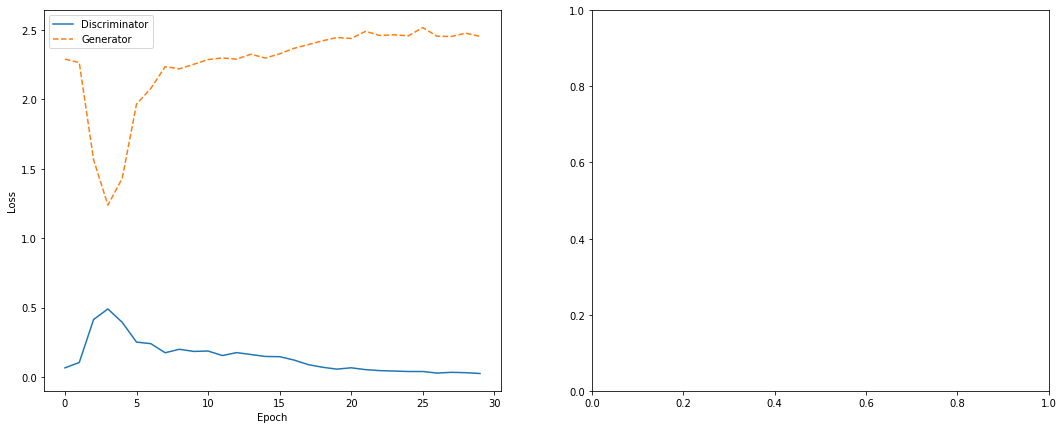

In [10]:
from torch.autograd import Variable
loss = nn.BCELoss()  #|  |l
                     #||  |_
    
my_generator1 = generator1().to(device)
my_discriminator1 = discriminator1().to(device)

# betas = (momentum, variance estimate)
generator_optim = torch.optim.Adam(my_generator1.parameters(), 2e-4, betas=(0.5, 0.9))#learning rate scheduler (from 0 to 2e-4 during ~30 first epochs)
discriminator_optim = torch.optim.Adam(my_discriminator1.parameters(), 2e-4, betas=(0.5, 0.9))

#lr_scheduler = np.linspace(0,2e-4,30)

discriminator_loss = []
generator_loss = []
d_loss = 1 #so we don't coinflip the first batch

# for one-sided label smoothing
prob = 0.1

# make figure for plotting
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# training loop
num_epochs = 30
for epoch in range(num_epochs):
    
    batch_d_loss, batch_g_loss = [], []
    for i, data in enumerate(zip(real_data_loader,attribute_loader,downsampled_loader,codej_loader)):
        (real_data,attributes, downsampled,codej) = data
        #convert real data to seven channels
        real_data = seven_channel_seg(np.array(real_data),batch_size)
        
        # coinflipper 9000
        if d_loss < 1e-1:
            #flip some fake labels such that they are true
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = (torch.rand(batch_size, 1)<prob).float().to(device)            
            
        else:
            #just ones and zeros
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)
        
        my_discriminator1.zero_grad()
        my_generator1.zero_grad()
        
        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        codej = Variable(codej).to(device)
        x_true = Variable(real_data).to(device)
        attributes = Variable(attributes).to(device)
        downsampled = Variable(downsampled).to(device)
        output = my_discriminator1(x_true,downsampled,attributes,codej)
        
        error_true = loss(output, true_label)
        error_true.backward()
        
        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        noise = torch.randn(batch_size, 100, 1,1)
        noise = Variable(noise, requires_grad=False).to(device)
        
        x_fake = my_generator1(downsampled,codej,attributes,noise)
        
        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = my_discriminator1(x_fake.detach(),downsampled,attributes,codej) 
        
        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()
        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = my_discriminator1(x_fake,downsampled,attributes,codej)
        
        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()
        
        d_loss = (error_true/(error_true + error_fake)).item()
        batch_d_loss.append(d_loss)
        batch_g_loss.append(error_generator.item())
        
        
        
    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    print("completed epoch {} with mean D loss {} and mean G loss {}".format(epoch+1,np.mean(batch_d_loss),np.mean(batch_g_loss)))
    

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Discriminator', 'Generator'])


In [23]:
print(discriminator_loss)

[0.41435886168110303, 0.47667849130011747, 0.4428735715966468, 0.21778012359282, 0.4156482542420008, 0.33686385121181955, 0.45819017909358306, 0.5277942467814682, 0.4707480182172731, 0.4434186002705246, 0.4430673934359561, 0.5271640479099006, 0.453206676710397, 0.4105492724195301, 0.5194123379395024, 0.36572845093905926, 0.5090424030520125, 0.4568493088707328, 0.3550200973171741, 0.4764281923910815, 0.5565298390691169, 0.4838436824269593, 0.4446151427813675, 0.29429555003298447, 0.4319084361168052, 0.510067535750568, 0.4738236156943458, 0.36198025273624806, 0.47676287284120916, 0.4159080721437931]


0.12114209312690152


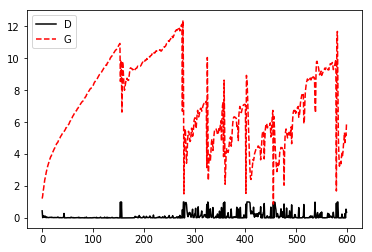

In [0]:
print(np.mean(batch_d_loss))
plt.plot(range(len(batch_d_loss)),batch_d_loss,'k-',range(len(batch_g_loss)),batch_g_loss,'r--')
plt.legend(['D','G'])

## Show generated segmentation

In [14]:
def show_new_segmentation(generator_output):
    imout = np.zeros((128,128))
    immax = np.zeros((128,128))
    for k,channel in enumerate(generator_output):
        for i,imrow in enumerate(channel):
            for j,imcol in enumerate(imrow):
                if float(imcol) > immax[i,j]:
                    imout[i,j] = k
                    immax[i,j] = float(imcol)
    return imout

# newseg = show_new_segmentation(result[0])
# print(newseg.shape)
# plt.imshow(newseg)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


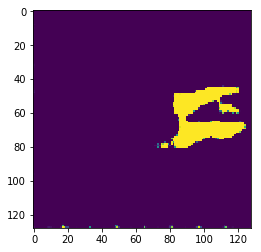

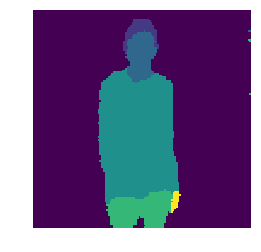

In [22]:
noise = torch.randn(n_data_points, 100, 1,1) #real noise
result = my_generator1.forward(downsampled_segmentation[:batch_size].to(device),codeJ[:batch_size].to(device),attribute_data[:batch_size].to(device),noise[:batch_size].to(device))
newseg1 = show_new_segmentation(result[3])
#newseg2 = show_new_segmentation(result[1])
plt.figure()
plt.imshow(np.array(result[2][4].cpu().detach()))
#plt.imshow(result[0,0])
plt.show()
plt.figure()
plt.imshow(np.transpose(newseg1))
plt.axis('off')
plt.savefig("seg.png")
plt.show()

## Training loop for GAN2

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


completed epoch 1 with mean D loss 0.3759351970771149 and mean G loss 1.4805528204794973
completed epoch 2 with mean D loss 0.30314615142673856 and mean G loss 1.54129095941782
completed epoch 3 with mean D loss 0.3776629663817522 and mean G loss 1.3826449157297611
completed epoch 4 with mean D loss 0.4067998013010265 and mean G loss 1.2871405286714435
completed epoch 5 with mean D loss 0.29540520065045045 and mean G loss 1.4919295063894242
completed epoch 6 with mean D loss 0.27134343882857576 and mean G loss 1.5590252204798163
completed epoch 7 with mean D loss 0.36512176923923007 and mean G loss 1.337014708854258
completed epoch 8 with mean D loss 0.259400392048445 and mean G loss 1.5319025545381009
completed epoch 9 with mean D loss 0.2226416384651731 and mean G loss 1.7637945417361334
completed epoch 10 with mean D loss 0.24932449911405372 and mean G loss 1.6954552341997624
completed epoch 11 with mean D loss 0.3328908314103051 and mean G loss 1.4393706174194814
completed epoch 12

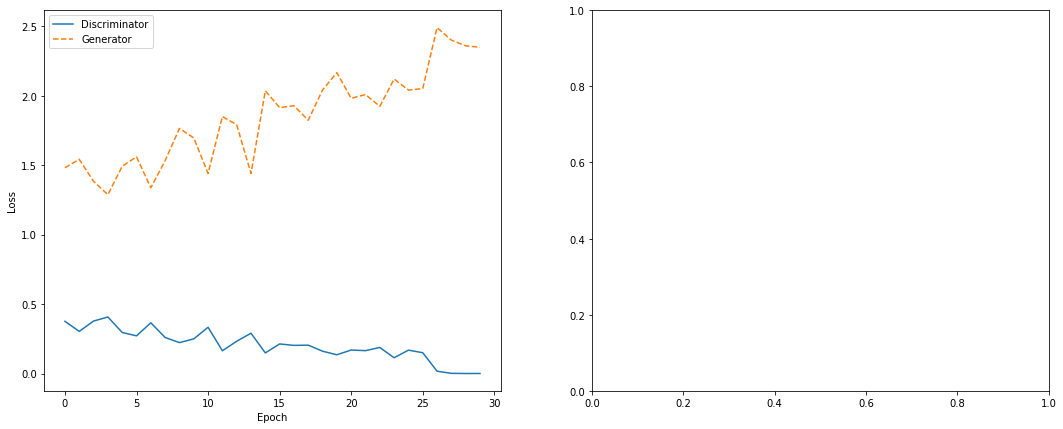

In [23]:
loss = nn.BCELoss()  #|  |l
                     #||  |_
    
my_generator2 = generator2().to(device)
my_discriminator2 = discriminator2().to(device)

generator_optim = torch.optim.Adam(my_generator2.parameters(), 2e-4, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(my_discriminator2.parameters(), 2e-4, betas=(0.5, 0.999))

discriminator_loss = []
generator_loss = []
d_loss = 1

# -- Plotting --
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# training loop
num_epochs = 30
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []
    for i, data in enumerate(zip(image_loader,attribute_loader,downsampled_loader,codej_loader)): #real data is the real image
        (real_data,attributes, downsampled,codej) = data
        
        
        noise = torch.randn(batch_size, 100, 1,1)
        noise = Variable(noise, requires_grad=False).to(device)
        
        # coinflipper 9000
        if d_loss < 1e-1:
            #flip some fake labels such that they are true
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = (torch.rand(batch_size, 1)<prob).float().to(device)            
            
        else:
            #just ones and zeros
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)
            
        my_discriminator2.zero_grad()
        my_generator2.zero_grad()
        
        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        codej = Variable(codej).to(device)
        x_true = Variable(real_data).to(device)
        attributes = Variable(attributes).to(device)
        downsampled = Variable(downsampled).to(device)
        g1_out = my_generator1.forward(downsampled,codej,attributes,noise).detach() #detach here to only train this GAN
        
        output = my_discriminator2(g1_out,x_true,attributes,codej)
        
        error_true = loss(output, true_label)
        error_true.backward()
        
        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        noise = torch.randn(batch_size, 100, 1,1)
        noise = Variable(noise, requires_grad=False).to(device)
        
        x_fake = my_generator2(attributes,noise,g1_out,codej)
        
        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = my_discriminator2(g1_out,x_fake.detach(),attributes,codej) 
        
        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()
        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = my_discriminator2(g1_out,x_fake,attributes,codej)
        
        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()
        d_loss = (error_true/(error_true + error_fake)).item()
        batch_d_loss.append(d_loss)
        batch_g_loss.append(error_generator.item())
        
        
    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    print("completed epoch {} with mean D loss {} and mean G loss {}".format(epoch+1,np.mean(batch_d_loss),np.mean(batch_g_loss)))
    

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(epoch+1), discriminator_loss)
ax.plot(np.arange(epoch+1), generator_loss, linestyle="--")
ax.legend(['Discriminator', 'Generator'])

## Additional Epochs

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


completed epoch 1 with mean D loss 0.06166090468014893 and mean G loss 2.355259511116892


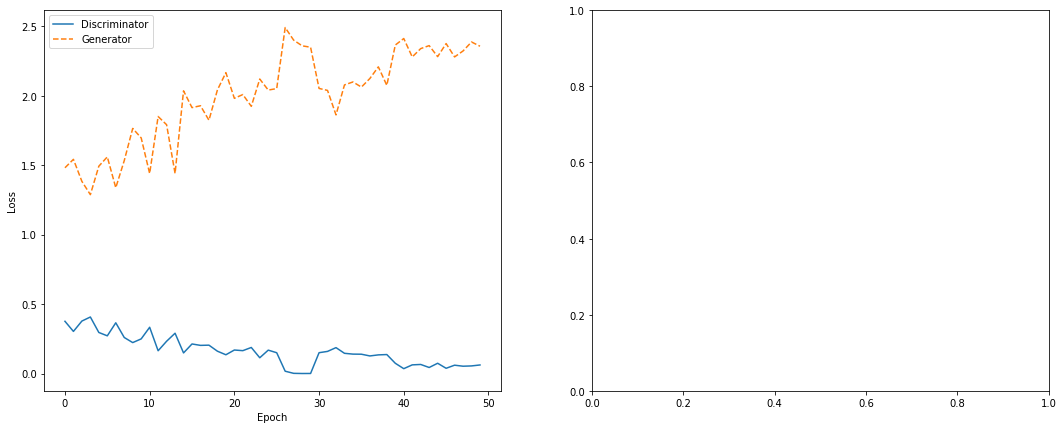

In [228]:
f, axarr = plt.subplots(1, 2, figsize=(18, 7))

# training loop MORE EPOCHS
num_epochs = 1
for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []
    for i, data in enumerate(zip(image_loader,attribute_loader,downsampled_loader,codej_loader)): #real data is the real image
        (real_data,attributes, downsampled,codej) = data
        
        
        noise = torch.randn(batch_size, 100, 1,1)
        noise = Variable(noise, requires_grad=False).to(device)
        
        # coinflipper 9000
        if d_loss < 1e-1:
            #flip some fake labels such that they are true
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = (torch.rand(batch_size, 1)<prob).float().to(device)            
            
        else:
            #just ones and zeros
            true_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)
            
        my_discriminator2.zero_grad()
        my_generator2.zero_grad()
        
        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        codej = Variable(codej).to(device)
        x_true = Variable(real_data).to(device)
        attributes = Variable(attributes).to(device)
        downsampled = Variable(downsampled).to(device)
        g1_out = my_generator1.forward(downsampled,codej,attributes,noise).detach() #detach here to only train this GAN
        
        output = my_discriminator2(g1_out,x_true,attributes,codej)
        
        error_true = loss(output, true_label)
        error_true.backward()
        
        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        noise = torch.randn(batch_size, 100, 1,1)
        noise = Variable(noise, requires_grad=False).to(device)
        
        x_fake = my_generator2(attributes,noise,g1_out,codej)
        
        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = my_discriminator2(g1_out,x_fake.detach(),attributes,codej) 
        
        error_fake = loss(output, fake_label)
        error_fake.backward()
        discriminator_optim.step()
        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = my_discriminator2(g1_out,x_fake,attributes,codej)
        
        error_generator = loss(output, true_label)
        error_generator.backward()
        generator_optim.step()
        d_loss = (error_true/(error_true + error_fake)).item()
        batch_d_loss.append(d_loss)
        batch_g_loss.append(error_generator.item())
        
        
    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    print("completed epoch {} with mean D loss {} and mean G loss {}".format(epoch+1,np.mean(batch_d_loss),np.mean(batch_g_loss)))
    

# Loss
ax = axarr[0]
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(len(discriminator_loss)), discriminator_loss)
ax.plot(np.arange(len(discriminator_loss)), generator_loss, linestyle="--")
ax.legend(['Discriminator', 'Generator'])

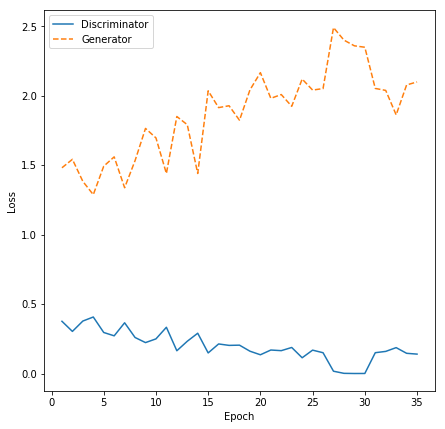

In [219]:
f, axarr = plt.subplots(1, 1, figsize=(7, 7))
ax = axarr
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.plot(np.arange(35)+1, discriminator_loss[:35])
ax.plot(np.arange(35)+1, generator_loss[:35], linestyle="--")
ax.legend(['Discriminator', 'Generator'])

## Show generated image

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


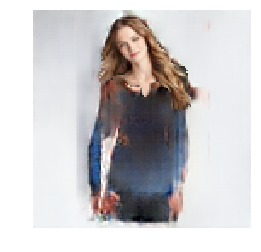

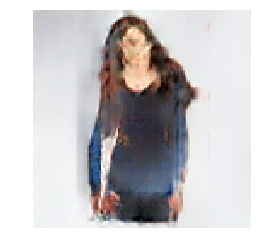

In [234]:
noise = torch.randn(n_data_points, 100, 1,1) #real noise
result = my_generator1.forward(downsampled_segmentation[:batch_size].to(device),codeJ[:batch_size].to(device),attribute_data[:batch_size].to(device),noise[:batch_size].to(device))

number_pic = 0
result2 = my_generator2.forward(attribute_data[:batch_size].to(device),noise[:batch_size].to(device),result.to(device),codeJ[:batch_size].to(device)).detach().cpu().numpy()[number_pic]
result2 = np.transpose(result2) + mean

nth_image = np.transpose(data[number_pic])+mean
nth_image[(np.transpose(segmentation[number_pic,0])!=1)&(np.transpose(segmentation[number_pic,0])!=2)] = 0

no_face = result2.copy()
no_face[no_face<0]=0
no_face[no_face>1]=1

result2[(np.transpose(segmentation[number_pic,0])==1)|(np.transpose(segmentation[number_pic,0])==2)] = 0
with_face = result2+nth_image
with_face[with_face<0]=0
with_face[with_face>1]=1
#with_face[np.transpose(result.detach().cpu().numpy()[number_pic,0])>0.95]=1
plt.imshow(with_face)
plt.axis('off')
plt.savefig("pic.png")
plt.figure()
plt.imshow(no_face)
plt.axis('off')
plt.savefig("pic_no_face.png")

the lady was wearing a blue long-sleeved blouse.


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


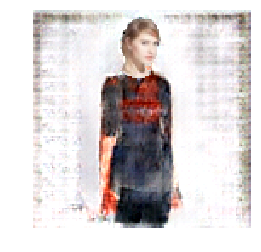

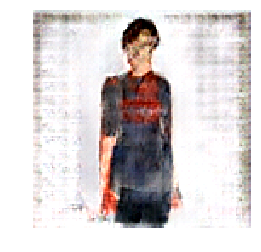

In [240]:
number_pic = 3
number_desc = 3

noise = torch.randn(1,100, 1,1) #real noise
result = my_generator1.forward(downsampled_segmentation[number_pic].view((1,4,8,8)).to(device),codeJ[number_desc].view((1,1,539)).to(device),attribute_data[number_pic].view((1,4,1,1)).to(device),noise.to(device))

result2 = my_generator2.forward(attribute_data[number_pic].view((1,4,1,1)).to(device),noise.to(device),result.to(device),codeJ[number_desc].view((1,1,539)).to(device)).detach().cpu().numpy()[0]
result2 = np.transpose(result2) + mean

print(annotations['engJ'][number_desc][0][0])

nth_image = np.transpose(data[number_pic])+mean
nth_image[(np.transpose(segmentation[number_pic,0])!=1)&(np.transpose(segmentation[number_pic,0])!=2)] = 0

no_face = result2.copy()
no_face[no_face<0]=0
no_face[no_face>1]=1

result2[(np.transpose(segmentation[number_pic,0])==1)|(np.transpose(segmentation[number_pic,0])==2)] = 0
with_face = result2+nth_image
with_face[with_face<0]=0
with_face[with_face>1]=1
#with_face[np.transpose(result.detach().cpu().numpy()[number_pic,0])>0.95]=1
plt.imshow(with_face)
plt.axis('off')
plt.savefig("pic.png")
plt.figure()
plt.imshow(no_face)
plt.axis('off')
plt.savefig("pic_no_face.png")

In [51]:
torch.cuda.empty_cache()

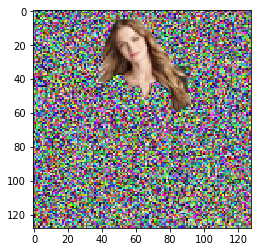

In [36]:
test_image = np.random.rand(128,128,3)
test_image[(np.transpose(segmentation[0,0])==1)|(np.transpose(segmentation[0,0])==2)] = 0
first_image = np.transpose(data[0])+mean
first_image[(np.transpose(segmentation[0,0])!=1)&(np.transpose(segmentation[0,0])!=2)]=0
with_face = test_image+first_image
with_face[with_face<0]=0
with_face[with_face>1]=1
plt.imshow(with_face)
#plt.imshow(first_image)
plt.show()

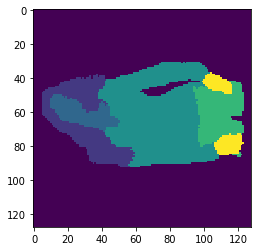

In [11]:
    plt.imshow(segmentation[0,0])

In [187]:
codeJ.shape

torch.Size([40000, 1, 539])

In [ ]:
torch.save()